#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 23
**CH 23 IMPORT DEMAND AND PRODUCTION**

version 0.9 2020-09-11

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from plotnine import *
import os
import sys
from datetime import datetime as dt
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

In [4]:
# Current script folder
current_path = os.getcwd()
dirname = "/".join(current_path.split("/")[:-2]) + "/"

# location folders
data_in = dirname + "da_data_repo/asia-industry/clean/"
data_out = dirname + "da_case_studies/ch23-import-demand-and-production/"
output = dirname + "da_case_studies/ch23-import-demand-and-production/output/"

func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [5]:
# Import the prewritten helper functions 
from py_helper_functions import *

In [6]:
# import data
raw = pd.read_stata(data_in + "asia-industry_tidy.dta")

In [7]:
data = raw.query("year >= 1998")

In [8]:
data = data.drop(data.query("(year==1998) & (month==1)").index)
data = data.drop(data.query("(year==2018) & (month > 4)").index)

In [9]:
data.groupby("countrycode").agg(
    mean=("ind_prod_const", "mean"),
    std_dev=("ind_prod_const", "first"),
    freq=("ind_prod_const", "count"),
).dropna().reset_index().sort_values(by="countrycode")

,countrycode,mean,std_dev,freq
0,CHN,2.046815e+11,4.956969e+10,243
1,IDN,2.729169e+10,1.591749e+10,243
2,MYS,8.150858e+09,4.526050e+09,243
3,PHL,7.193672e+09,6.599710e+09,243
4,SGP,4.840317e+09,2.324321e+09,243
5,THA,9.791123e+09,5.602920e+09,243
6,TWN,1.171419e+10,6.744322e+09,242
7,USA,2.640678e+11,2.344603e+11,243


In [10]:
# feature engineering

In [11]:
data = data.merge(
    data.groupby("time")
    .apply(
        lambda x: max(np.where(x["countrycode"] == "USA", x["ind_prod_const_sa"], 0))
    )
    .reset_index()
    .rename(columns={0: "usa_ip_sa"}),
    on="time",
)

In [12]:
data = data.merge(
    data.groupby("time")
    .apply(
        lambda x: max(np.where(x["countrycode"] == "CHN", x["ind_prod_const_sa"], 0))
    )
    .reset_index()
    .rename(columns={0: "chn_ip_sa"}),
    on="time",
)

In [13]:
data["ln_ip"] = np.log(data["ind_prod_const_sa"] + 1)
data["ln_usa_ip"] = np.log(data["usa_ip_sa"] + 1)
data["ln_chn_ip"] = np.log(data["chn_ip_sa"] + 1)
data["ln_usa_imports"] = np.log(data["usa_imp_sa"] + 1)
data["ln_er_usd"] = np.log(data["exchnage_rate_vs_usd"] + 1)

In [14]:
data = data.dropna(subset=["ln_ip"])

In [15]:
# keep countries of choice
data = data.query(
    "(countrycode == 'MYS') | (countrycode == 'PHL') | (countrycode == 'SGP') | (countrycode == 'THA')"
)

In [16]:
data.groupby("countrycode")["country"].count()

countrycode
MYS    243
PHL    243
SGP    243
THA    243
Name: country, dtype: int64

In [17]:
# panel setup
# encode country , gen(cc)
# sort cc time
# tsset cc time

In [18]:
data["cc"] = data["countrycode"].astype("category")

In [19]:
# lagged variables
work = data.sort_values(by=["cc","time"])

In [20]:
work["dln_ip"] = work.groupby("cc")["ln_ip"].transform("diff")
work["dln_usa_ip"] = work.groupby("cc")["ln_usa_ip"].transform("diff")
work["dln_chn_ip"] = work.groupby("cc")["ln_chn_ip"].transform("diff")
work["dln_usa_imports"] = work.groupby("cc")["ln_usa_imports"].transform("diff")
work["dln_er_usd"] = work.groupby("cc")["ln_er_usd"].transform("diff")

In [21]:
work.groupby("countrycode").agg(mean=("dln_ip", np.nanmean))

,mean
countrycode,
MYS,0.003534
PHL,0.002520
SGP,0.004417
THA,0.003536


In [22]:
# create time variables
work["date"] = (work["year"].astype(str) + "-" + data["month"].astype(str)).apply(
    lambda x: dt.strptime(x, "%Y-%m")
)

In [23]:
work.query("countrycode == 'THA'").groupby("year")["country"].count()

year
1998    11
1999    12
2000    12
2001    12
2002    12
2003    12
2004    12
2005    12
2006    12
2007    12
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018     4
Name: country, dtype: int64

In [24]:
np.nanmean(work.query("countrycode == 'THA'")["dln_ip"])

0.0035356345999866365

In [25]:
work.loc[work["date"] == "2008-11-01","date"].values[0]

numpy.datetime64('2008-11-01T00:00:00.000000000')

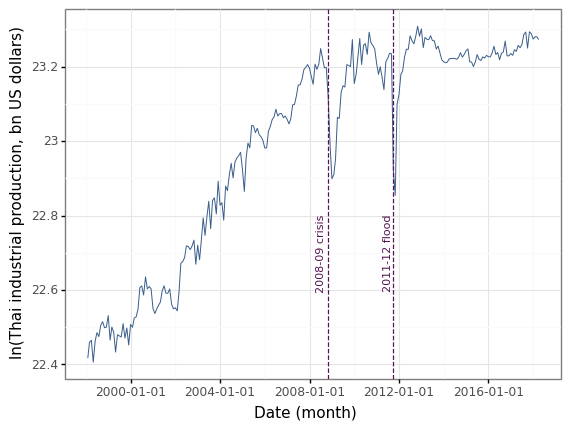

<ggplot: (326594497)>

In [26]:
ggplot(work.loc[work["country"] == "Thailand"], aes(x="date", y="ln_ip")) + geom_line(
    color=color[0], size=0.4
) + theme_bw() + xlab("Date (month)") + ylab(
    "ln(Thai industrial production, bn US dollars)"
) + geom_vline(
    xintercept=work.loc[work["date"] == "2008-11-01", "date"].values[0],
    linetype="dashed",
    color=color[2],
    size=0.5,
) + annotate(
    "text",
    size=8,
    color=color[2],
    label="2008-09 crisis",
    y=22.7,
    x=work.loc[work["date"] == "2008-07-01", "date"].values[0],
    angle=90,
) + geom_vline(
    xintercept=work.loc[work["date"] == "2011-10-01", "date"].values[0],
    linetype="dashed",
    color=color[2],
    size=0.5,
) + annotate(
    "text",
    size=8,
    color=color[2],
    label="2011-12 flood",
    y=22.7,
    x=work.loc[work["date"] == "2011-07-01", "date"].values[0],
    angle=90,
) + scale_x_datetime(
    date_breaks="4 year"
)

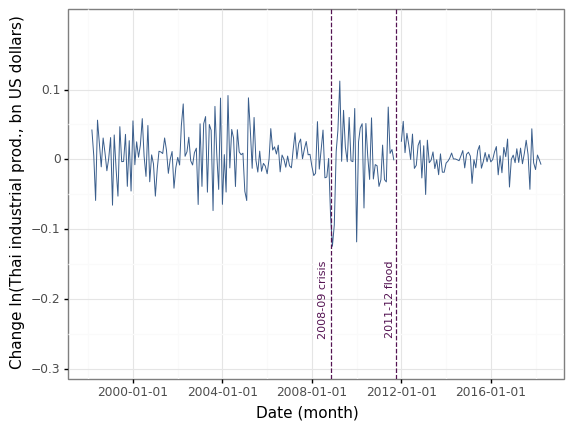

<ggplot: (326693102)>

In [27]:
ggplot(work.loc[work["country"] == "Thailand"], aes(x="date", y="dln_ip")) + geom_line(
    color=color[0], size=0.4
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(-0.3, 0.2), breaks=np.arange(-0.3, 0.2, 0.1)
) + theme_bw() + xlab(
    "Date (month)"
) + ylab(
    "Change ln(Thai industrial prod., bn US dollars)"
) + geom_vline(
    xintercept=work.loc[work["date"] == "2008-11-01", "date"].values[0],
    linetype="dashed",
    color=color[2],
    size=0.5,
) + annotate(
    "text",
    size=8,
    color=color[2],
    label="2008-09 crisis",
    y=-0.2,
    x=work.loc[work["date"] == "2008-07-01", "date"].values[0],
    angle=90,
) + geom_vline(
    xintercept=work.loc[work["date"] == "2011-10-01", "date"].values[0],
    linetype="dashed",
    color=color[2],
    size=0.5,
) + annotate(
    "text",
    size=8,
    color=color[2],
    label="2011-12 flood",
    y=-0.2,
    x=work.loc[work["date"] == "2011-07-01", "date"].values[0],
    angle=90,
) + scale_x_datetime(
    date_breaks="4 year"
)

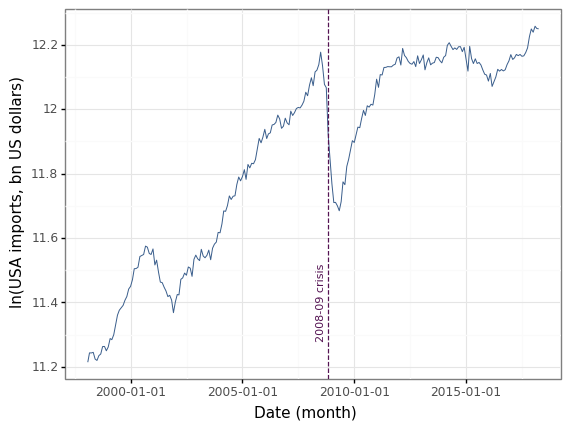

<ggplot: (287390004)>

In [28]:
ggplot(work, aes(x="date", y="ln_usa_imports")) + geom_line(
    color=color[0], size=0.4
) + theme_bw() + xlab("Date (month)") + ylab(
    "ln(USA imports, bn US dollars)"
) + scale_y_continuous(
    breaks=np.arange(11.2, 12.3, 0.2)
) + geom_vline(
    xintercept=work.loc[work["date"] == "2008-11-01", "date"].values[0],
    linetype="dashed",
    color=color[2],
    size=0.5,
) + annotate(
    "text",
    size=8,
    color=color[2],
    label="2008-09 crisis",
    y=11.4,
    x=work.loc[work["date"] == "2008-07-01", "date"].values[0],
    angle=90,
)

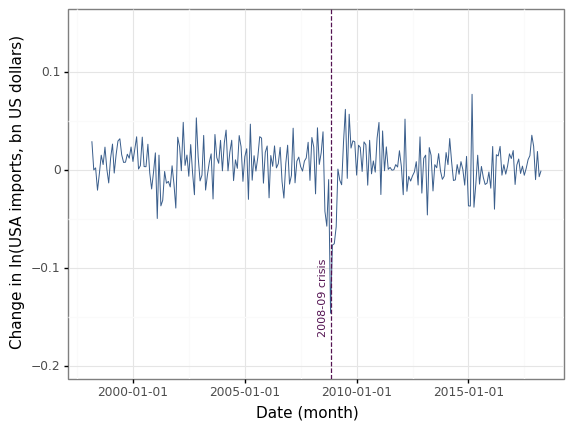

<ggplot: (326752570)>

In [29]:
ggplot(work, aes(x="date", y="dln_usa_imports")) + geom_line(
    color=color[0], size=0.4
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(-0.2, 0.15), breaks=np.arange(-0.2, 0.16, 0.1)
) + theme_bw() + xlab(
    "Date (month)"
) + ylab(
    "Change in ln(USA imports, bn US dollars)"
) + geom_vline(
    xintercept=work.loc[work["date"] == "2008-11-01", "date"].values[0],
    linetype="dashed",
    color=color[2],
    size=0.5,
) + annotate(
    "text",
    size=8,
    color=color[2],
    label="2008-09 crisis",
    y=-0.13,
    x=work.loc[work["date"] == "2008-07-01", "date"].values[0],
    angle=90,
)

In [30]:
# REGRESSIONS

# Serial correlation matters because it may lead to biased standard error estimates.
# We recommended two ways to address this problem: estimate Newey–West standard errors
# or include the lag of the dependent variable in the regression. (Used here.)

In [31]:
lags_usa = " + ".join(["dln_usa_imports.shift({i})".format(i=i)for i in range(0,5)])
lags_ip =  " + ".join(["dln_ip.shift({i})".format(i=i)for i in range(1,3)])

thai_formula = "dln_ip ~ " + lags_usa + " + " + lags_ip

In [33]:
smf.ols(thai_formula, work.query("countrycode == 'THA'")).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 dln_ip   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     3.470
Date:                Mon, 08 Feb 2021   Prob (F-statistic):            0.00149
Time:                        11:41:13   Log-Likelihood:                 424.62
No. Observations:                 238   AIC:                            -833.2
Df Residuals:                     230   BIC:                            -805.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0024      0.003      0.849      0.397      -0.003       0.008
dln_usa_imports.shift(0)     0.3430      0.121      2.846      0.005       0.106       0.580
dln_usa_imports.shift(1)     0.2805      0.122      2.301      0.022       0.040       0.521
dln_usa_imports.shift(2)     0.1851      0.115      1.603      0.110      -0.042       0.412
dln_usa_imports.shift(3)    -0.1226      0.120     -1.020      0.309      -0.359       0.114
dln_usa_imports.shift(4)    -0.1940      0.120     -1.620      0.107      -0.430       0.042
dln_ip.shift(1)             -0.1383      0.065     -2.142      0.033      -0.265      -0.011
dln_ip.shift(2)             -0.1630      0.064     -2.537      0.012      -0.290      -0.036
==============================================================================
Omnibus:                      130.425   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2412.659
Skew:                          -1.692   Prob(JB):                         0.00
Kurtosis:                      18.226   Cond. No.                         54.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
# long-term coeff, lagged dy, countries separately
lags_usa = " + ".join(["dln_usa_imports.shift({i}).diff()".format(i=i)for i in range(0,4)])
lt_formula = "dln_ip ~ dln_usa_imports.shift(4) + " + lags_usa + "+ dln_ip.shift(1)"

In [35]:
tha_reg_lt = smf.ols(lt_formula, work.query("countrycode == 'THA'")).fit(cov_type="HC0")
mys_reg_lt = smf.ols(lt_formula, work.query("countrycode == 'MYS'")).fit(cov_type="HC0")
phl_reg_lt = smf.ols(lt_formula, work.query("countrycode == 'PHL'")).fit(cov_type="HC0")
sgp_reg_lt = smf.ols(lt_formula, work.query("countrycode == 'SGP'")).fit(cov_type="HC0")

In [36]:
# long-term coeff, lagged dy, countries pooled
lt_formula_pooled = (
    "dln_ip ~ dln_usa_imports.shift(4) + " + lags_usa + " + dln_ip.shift(1) + cc"
)
pooled_reg_lt = smf.ols(lt_formula_pooled, work).fit(cov_type="HC0")

In [43]:
models = [tha_reg_lt, mys_reg_lt, phl_reg_lt, sgp_reg_lt, pooled_reg_lt]
names = ["Thailand", "Malaysia", "Philippines", "Singapore", "Pooled"]
stargazer = Stargazer(models)
stargazer.rename_covariates(
    {
        "Intercept": "Constant",
        "dln_usa_imports.shift(4)": "USA imports log change, cumulative coeff.",
        "dln_ip.shift(1)": "Industrial production log change, lag",
        "cc[T.PHL]": "Philippines",
        "cc[T.SGP]": "Singapore",
        "cc[T.THA]": "Thailand",
    }
)
stargazer.covariate_order(
    [
        "dln_usa_imports.shift(4)",
        "dln_ip.shift(1)",
        "cc[T.SGP]",
        "cc[T.PHL]",
        "cc[T.THA]",
        "Intercept",
    ]
)
stargazer.custom_columns(names, [1, 1, 1, 1, 1])
HTML(stargazer.render_html())